<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-de-aprendizaje-murasakiw/blob/main/kmeans_target_A01794338.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ciencia y Analítica de Datos
 ___ 
Actividad Semanal 7: Regresiones y K-means  
Nombre: Sergio Omar Esparza Hernández  
Matrícula: A01794338

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [1]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.7 MB 25.9 MB/s 
     |████████████████████████████████| 1.0 MB 44.1 MB/s 
     |████████████████████████████████| 1.7 MB 42.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 179 kB 54.3 MB/s 
     |████████████████████████████████| 6.3 MB 47.5 MB/s 
  Created wheel for qeds: filename=qeds-0.7.0-py3-none-any.whl size=27812 sha256=d510f3cd7b2d15b2ba058d773416f33024e5502f90693b49ea6b6492a0a733af
  Stored in directory: /root/.cache/pip/wheels/fc/8c/52/0cc036b9730b75850b9845770780f8d05ed08ff38a67cbaa29
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=8b00e55b8c1e874f6cea8f54cc325ceab328fed8420ea7a0212c6c5067aaab29
  Stored in directory: /root/

In [119]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas

Importa la base de datos

In [120]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [121]:

df.head()


,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [123]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

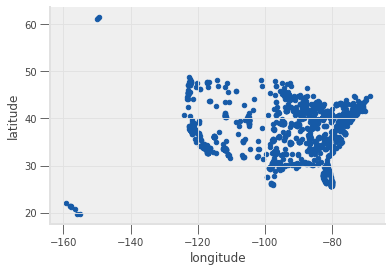

In [124]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [125]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [126]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [127]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [128]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [129]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [130]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

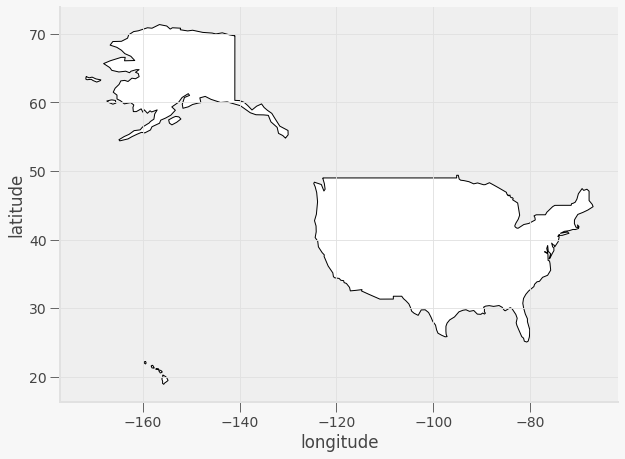

In [131]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

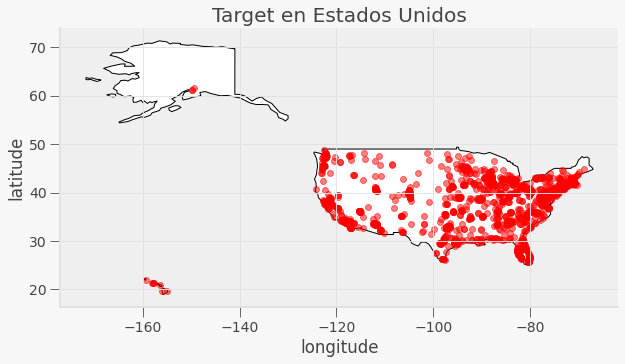

In [132]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [177]:
from sklearn.cluster import KMeans

In [186]:
#tu codigo aquí
k_max = 10 #Número de clusters

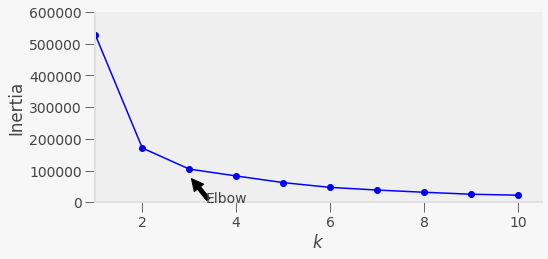

In [189]:
kmeans_per_k = [KMeans(n_clusters=k).fit(latlong)
                for k in range(1, k_max+1)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, k_max+1), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(3, inertias[3]), xytext=(3.45, 650),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(3.8, 650, "Elbow", horizontalalignment="center")
plt.axis([1, 10.5, 0, 600000])
plt.grid()
# save_fig("inertia_vs_k_plot")
plt.show()

In [190]:
from sklearn.metrics import silhouette_score

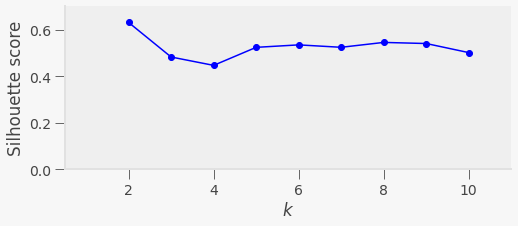

In [191]:
silhouette_scores = [silhouette_score(latlong, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, k_max+1), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.axis([0.5, k_max+1, 0.0, 0.7])
plt.grid()
plt.show()

In [192]:
target_kmeans = KMeans(n_clusters=5)
y_pred = target_kmeans.fit_predict(latlong)

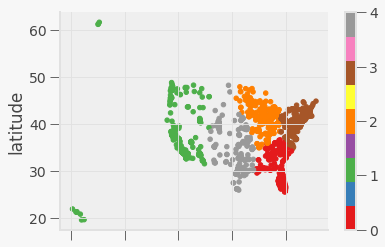

In [193]:
latlong.plot.scatter( "longitude","latitude", c=y_pred, colormap='Set1');

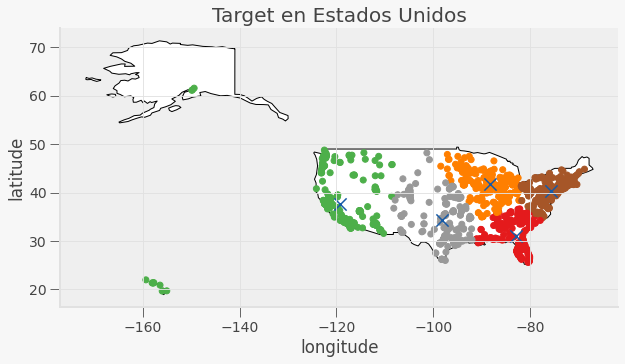

In [194]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, column=y_pred, cmap='Set1')
plt.scatter(target_kmeans.cluster_centers_[:,1], target_kmeans.cluster_centers_[:,0], marker='x', s=150)
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [195]:
target_kmeans.cluster_centers_

array([[  31.08686259,  -82.91837107],
       [  37.57977424, -119.17634307],
       [  41.7454415 ,  -88.35163457],
       [  40.34365502,  -75.58507975],
       [  34.42035677,  -98.26633716]])

In [226]:
a = pd.DataFrame(pd.Series(y_pred).value_counts())

In [228]:
a = a.sort_index()
a.head()

,0
0,273
1,368
2,422
3,480
4,296


In [197]:
df_clusters = latlong.copy()
df_1 = pd.DataFrame(y_pred)

In [198]:
df_c = df_clusters.assign(clusters=pd.Series(y_pred))

* Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?, ¿a cuantas tiendas va surtir?, ¿sabes a que distancia estará?

Ubicación de los almacenes, ciudades y tiendas atendidas por almacén.

In [233]:
ciudades = ['Georgia', 'California', 'Aurora, Illinois', 'Pennsylvania', 'Walters, Oklahoma']
for i in range(len(ciudades)):
  print(f'Almacén: {ciudades[i]}, Ubicación: {target_kmeans.cluster_centers_[i]}, Tiendas atendidas: {a[0][i]}')

Almacén: Georgia, Ubicación: [ 31.08686259 -82.91837107], Tiendas atendidas: 273
Almacén: California, Ubicación: [  37.57977424 -119.17634307], Tiendas atendidas: 368
Almacén: Aurora, Illinois, Ubicación: [ 41.7454415  -88.35163457], Tiendas atendidas: 422
Almacén: Pennsylvania, Ubicación: [ 40.34365502 -75.58507975], Tiendas atendidas: 480
Almacén: Walters, Oklahoma, Ubicación: [ 34.42035677 -98.26633716], Tiendas atendidas: 296


* ¿Cómo elegiste el número de almacenes?, justifica tu respuesta técnicamente.

Elegí el número de almacenes basándome en la gráfica de silhouette scores y en la gráfica de inercia. En la gráfica de inercia se observa que el codo se forma en 3 clusters, sin embargo, en la gráfica de silhouette scores se oberva que el número más apropiado de clusters está entre 5 y 9. Para tomar la decisión me apoyé en la gráfica de las ubicaciones de las tiendas, pero separadas por colores por cluster. Con base en lo anterior, seleccioné el número de 5 clusters para que cada almacén atendiera una buena cantidad de tiendas. A partir de k=6, algunos clusters agrupaban muy pocas tiendas, esto también fue un factor importante para seleccionar 5 almacenes(clusters).

Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.

* ¿Qué librerías nos pueden ayudar a graficar este tipo de datos?

Para trabajar con datos geo espaciales se puede utilizar la librería geopandas que es una extensión de la librería pandas. Adicionalmente, esta librería se apoya en matplotlib para graficar los datos. De igual manera se utiliza shapely para la manipulación de objetos geométricos en el plano.

Folium es otra librería muy útil para la visualización geoespacial en python, plotly y Kepler son otras opciones, y dependerá de los requerimientos del proyecto seleccionar la librería adecuada. Existe varias opciones para ayudar con la visualización de datos geoespaciales.


* ¿Consideras importante que se grafique en un mapa?, ¿por qué?  

Sí, es muy importante graficar los datos en un mapa porque ayuda a comprender mejor los resultados. En mi caso me ayudó a reducir el tiempo de comprensión de los resultados obtenidos después de aplicar el modelo de k-means. Otra ventaja de graficar los resultados, es que se puede utilizar para comunicar con mayor facilidad los resultados a otras personas que no están familizarizadas con los aspectos técnicos de los modelos de machine learning. 

Conclusiones  

El método de agrupamiento k-means es muy fácil de implementar utilizando sci-kit learn, y es un método que no requiere de mucho tiempo para arrojar resultados, por lo tanto, resulta muy adecuado para obtener una primera aproximación en un problema de aprendizaje no supervisado. Observé que es importante la visualización en los problemas geo espaciales, ya que, existen condiciones geográficas que afectan indirectamente en los resultados obtenidos por la agrupación, por ejemplo, las tiendas ubicadas en Hawaii y Alaska se encuentran bastante alejadas de los demás puntos pertenecientes a ese cluster. Este tipo de detalles son importantes y solo pueden ser detectados si se utiliza alguna herramienta de visualización para comprender mejor los datos y los resultados obtenidos del modelo aplicado.